# DivExplorer analysis - Example with COMPAS dataset 

In [39]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import dataset

In this running example we analyze the [COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) dataset.

We import an already pre-processed and discretized version. You can refer to this [notebook](www.google.com) for its pre-processing.

The COMPAS dataset contains demographic information and the criminal history of defendants.
For each criminal defendant, the following attributes are available:
- *age_cat*: age category of the defendant. 
- *c_charge_degree*: severity of the charge. 'M'='Misdemeanor','F'='Felony' 
- *race*: 'Afr-Am', 'Asian', 'Cauc', 'Hispanic', 'Native American', 'Other'
- *sex*: 'Female', 'Male'
- *length_of_stay*: the days spent in jail, derived from the records of the date in which the person entered lastly the jail and the date in which the person was released.
- *priors_count*: the number of prior crimes committed.


For each defendant, the dataset also records:
- the *class*, whether the defendant recidivated (was arrested again) in the next two years. It is 1 if the defendant recidivated, 0 otherwise.
- the *predicted* recidivism, derived from the COMPAS score of recidivism risk assesses the defendant’s likelihood of committing another offense in a period of two years. It is 1 if the risk is high.

In [80]:
def get_true_positives(y_trues, y_preds, positive_value=1):
    """Returns true positives. True if it is a true positive, false otherwise."""

    return ((y_trues == y_preds) & (y_trues == positive_value))

def get_true_negatives(y_trues, y_preds, negative_value=1):
    """Returns true negatives. True if it is a true negative, false otherwise."""

    return ((y_trues == y_preds) & (y_trues == negative_value))

def get_false_positives(y_trues, y_preds, negative_value=1):
    """Returns false positives. True if it is a false positive, false otherwise."""

    return ((y_trues != y_preds) & (y_trues == negative_value))

def get_false_negatives(y_trues, y_preds, positive_value=1):
    """Returns false negatives. True if it is a false negative, false otherwise."""

    return ((y_trues != y_preds) & (y_trues == positive_value))

def get_false_positive_rate_outcome(y_trues, y_preds, negative_value=0, positive_value=1):
    """Returns boolean outcome for the false positive rate. 1 if it is a false positive, 0 if it is a true negative, np.nan otherwhise.
    """
    import numpy as np

    fp = np.array(get_false_positives(y_trues, y_preds, negative_value=negative_value)).astype(int)
    tn = np.array(get_true_negatives(y_trues, y_preds, negative_value=negative_value)).astype(int)

    fp_outcome = np.full(fp.shape, np.nan)
    fp_outcome[fp == 1] = 1
    fp_outcome[tn == 1] = 0


    return fp_outcome

def get_false_negative_rate_outcome(y_trues, y_preds, negative_value=0, positive_value=1):
    """Returns boolean outcome for the false negative rate. 1 if it is a false negative, 0 if it is a true positive, np.nan otherwhise.
    """
    import numpy as np

    fn = np.array(get_false_negatives(y_trues, y_preds, positive_value=positive_value)).astype(int)
    tp = np.array(get_true_positives(y_trues, y_preds, positive_value=positive_value)).astype(int)

    fn_outcome = np.full(fn.shape, np.nan)
    fn_outcome[fn == 1] = 1
    fn_outcome[tp == 1] = 0


    return fn_outcome

def get_accuracy_outcome(y_trues, y_preds, negative_value=0, positive_value=1):
    """Returns boolean outcome for the accuracy rate. 1 if it is correct, 0 if it is incorrect
    """
    import numpy as np

    fn = np.array(get_false_negatives(y_trues, y_preds, positive_value=positive_value)).astype(int)
    tp = np.array(get_true_positives(y_trues, y_preds, positive_value=positive_value)).astype(int)
    fp = np.array(get_false_positives(y_trues, y_preds, negative_value=negative_value)).astype(int)
    tn = np.array(get_true_negatives(y_trues, y_preds, negative_value=negative_value)).astype(int)

    acc_outcome = np.full(y_trues.shape, np.nan)
    acc_outcome[(tp == 1) | (tn == 1)] = 1
    acc_outcome[(fp == 1) | (fn == 1)] = 0

    return acc_outcome

In [41]:
import os
inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df = pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


In [42]:
y_trues = df["class"].values
y_preds = df["predicted"].values

In [43]:
df['fpr_outcome'] =  get_false_positive_rate_outcome(y_trues, y_preds, negative_value=0)

In [44]:
df = df.drop(columns=['class', 'predicted'])  

# Compute pattern divergence

With DivExplorer, we can compute the the performance metrics and the divergence scores of *all* itemsets whose frequency in the dataset is above a minimum frequency threshold (min_sup).

In [45]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, boolean_outcomes = ['fpr_outcome'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

,support,itemsets,fpr_outcome,fpr_outcome_div,fpr_outcome_t,length,support_count
0,1.000000,(),0.088314,0.000000,0.000000,0,6172.0
1,0.809624,(sex=Male),0.093810,0.005496,0.738697,1,4997.0
2,0.772683,(stay=<week),0.072043,-0.016271,2.339352,1,4769.0
3,0.643227,(charge=F),0.107754,0.019440,2.301183,1,3970.0
4,0.614226,"(sex=Male, stay=<week)",0.076379,-0.011935,1.555571,2,3791.0
5,0.572262,(age=25-45),0.088842,0.000528,0.087728,1,3532.0
6,0.532404,"(sex=Male, charge=F)",0.111041,0.022727,2.471729,2,3286.0
7,0.514420,(race=Afr-Am),0.139366,0.051052,5.046409,1,3175.0
8,0.471484,"(charge=F, stay=<week)",0.088179,-0.000135,0.016780,2,2910.0
9,0.460629,"(sex=Male, age=25-45)",0.096377,0.008063,0.914899,2,2843.0


In [46]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'fpr_outcome')

pattern = fp_diver.patterns['itemsets'].iloc[30]
print(pattern)

sv = fp_diver.shapley_value(pattern)
sv

frozenset({'stay=<week', '#prior=[1,3]'})


{frozenset({'stay=<week'}): -0.01534083615290903,
 frozenset({'#prior=[1,3]'}): -0.014328073142832076}

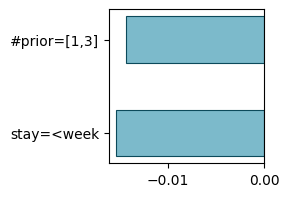

In [47]:
fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2))

In [48]:
fp_diver.redundancy_pruning(th_redundancy=0.05)

,support,itemsets,length,support_count,fpr_outcome,fpr_outcome_div,fpr_outcome_t
0,1.000000,(),0,6172.0,0.088314,0.000000,0.000000
7,0.514420,(race=Afr-Am),1,3175.0,0.139366,0.051052,5.046409
28,0.293422,(#prior=>3),1,1811.0,0.219269,0.130955,7.503321
44,0.218244,(age=<25),1,1347.0,0.177066,0.088752,5.456070
47,0.209494,(age=>45),1,1293.0,0.027304,-0.061010,8.097262
65,0.177090,(stay=1w-3M),1,1093.0,0.151786,0.063472,3.668118


In [49]:
gsv = fp_diver.global_shapley_value()

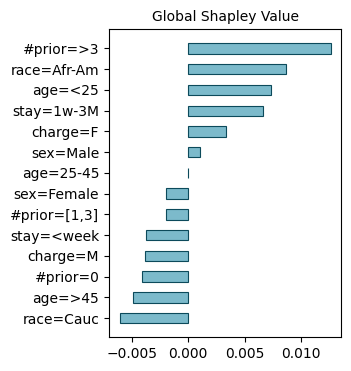

In [50]:
fp_diver.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')

## Quantitative 

In [51]:
import os
import numpy as np

inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df= pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))

# This is just for test purposes
df['score'] = [np.random.uniform() for i in range(len(df))]
df.drop(columns=['class', 'predicted'], inplace=True)

In [52]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, quantitative_outcomes = ['score'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

,support,itemsets,score,score_SQUARED,score_div,score_t,length,support_count
0,1.000000,(),0.498786,2047.536465,0.000000,0.000000,0,6172.0
1,0.809624,(sex=Male),0.499190,1660.025262,0.000403,0.073569,1,4997.0
2,0.772683,(stay=<week),0.500978,1593.293664,0.002192,0.394545,1,4769.0
3,0.643227,(charge=F),0.495181,1297.684424,-0.003605,0.618182,1,3970.0
4,0.614226,"(sex=Male, stay=<week)",0.500588,1264.808803,0.001802,0.303035,2,3791.0
5,0.572262,(age=25-45),0.496975,1166.383520,-0.001811,0.297708,1,3532.0
6,0.532404,"(sex=Male, charge=F)",0.495560,1075.750850,-0.003227,0.521159,2,3286.0
7,0.514420,(race=Afr-Am),0.498979,1054.742806,0.000193,0.030638,1,3175.0
8,0.471484,"(charge=F, stay=<week)",0.498656,962.992060,-0.000130,0.020141,2,2910.0
9,0.460629,"(sex=Male, age=25-45)",0.495101,934.255946,-0.003685,0.563227,2,2843.0


frozenset({'#prior=0', 'race=Afr-Am'})
{frozenset({'#prior=0'}): -0.013172190989201027, frozenset({'race=Afr-Am'}): -0.0013792359222325468}


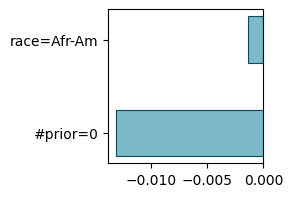

In [53]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'score')

pattern = fp_diver.patterns['itemsets'].iloc[100]
print(pattern)

sv = fp_diver.shapley_value(pattern)
print(sv)
fp_diver.plot_shapley_value(shapley_values=sv, figsize=(2,2))

# Quantitative outcomes - multiple

In [67]:
import os
inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df = pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


In [81]:
y_trues = df["class"].values
y_preds = df["predicted"].values

df['fnr_outcome'] = get_false_negative_rate_outcome(y_trues, y_preds, negative_value=0, positive_value=1)
df['acc_outcome'] = get_accuracy_outcome(y_trues, y_preds, negative_value=0, positive_value=1)

In [82]:
df = df.drop(columns=['class', 'predicted'])  

In [84]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, boolean_outcomes = ['fnr_outcome', 'acc_outcome'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

,support,itemsets,fnr_outcome,fnr_outcome_div,fnr_outcome_t,acc_outcome,acc_outcome_div,acc_outcome_t,length,support_count
0,1.000000,(),0.698469,0.000000,0.000000,0.633992,0.000000,0.000000,0,6172.0
1,0.809624,(sex=Male),0.687396,-0.011074,0.864525,0.621573,-0.012419,1.350598,1,4997.0
2,0.772683,(stay=<week),0.751390,0.052920,4.059364,0.646047,0.012055,1.301787,1,4769.0
3,0.643227,(charge=F),0.658770,-0.039699,2.896145,0.616877,-0.017116,1.738770,1,3970.0
4,0.614226,"(sex=Male, stay=<week)",0.740120,0.041651,3.011311,0.631232,-0.002760,0.280104,2,3791.0
5,0.572262,(age=25-45),0.692261,-0.006208,0.440574,0.630804,-0.003188,0.316438,1,3532.0
6,0.532404,"(sex=Male, charge=F)",0.648442,-0.050027,3.464983,0.610773,-0.023219,2.217517,2,3286.0
7,0.514420,(race=Afr-Am),0.618302,-0.080167,5.445090,0.610079,-0.023913,2.257649,1,3175.0
8,0.471484,"(charge=F, stay=<week)",0.708550,0.010081,0.656175,0.625086,-0.008906,0.823671,2,2910.0
9,0.460629,"(sex=Male, age=25-45)",0.676087,-0.022382,1.472716,0.622230,-0.011762,1.076807,2,2843.0


frozenset({'stay=<week', '#prior=[1,3]'})


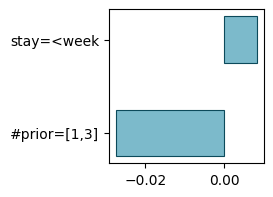

In [85]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'acc_outcome')

pattern = fp_diver.patterns['itemsets'].iloc[30]
print(pattern)

fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2))

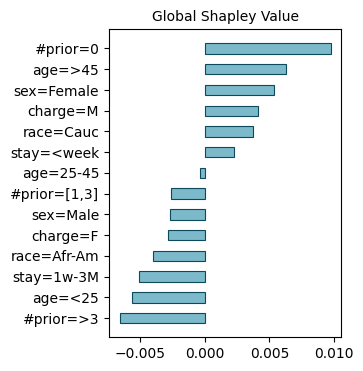

In [86]:
gsv = fp_diver.global_shapley_value()
fp_diver.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')